# Title
## B/Ca to Omega calibration

First we'll import the Yu & Elderfield (2007) dataset as a pandas df

In [2]:

from pathlib import Path
import os
import pandas as pd

cwd=Path(os.getcwd())
data_path=cwd.parent.absolute()/"data"
file_path=data_path/"Yu_Elderfield_calibration.xlsx"
Yu_Elder_df=pd.read_excel(file_path)

Then convert depth to pressure


In [3]:

def depth_m_to_pressure_bar(depth):
    pressure_bar=1023.6*9.80665*depth*10**-5
    return pressure_bar

Yu_Elder_df['pressure_bar']=depth_m_to_pressure_bar(Yu_Elder_df['water_depth_m'].values)


Generate Ksp values (both calcite and aragonite) using the dataset pressures and temperatures. We assume salinity, \[Ca], and \[Mg]. 

Generate \[$CO_3^{2-}$ ]$_{sat, a}$ \& \[$CO_3^{2-}$ ]$_{sat, c}$ from Ksp.
$$
\left[CO_3^{2-} \right]_{sat} = \frac{K_{sp}}{\left[Ca\right]_{sw}} 

$$

Then $\Omega$:

$$
\Omega = \frac{\Delta\left[CO_3^{2-} \right]+\left[CO_3^{2-} \right]_{sat}}{\left[CO_3^{2-} \right]_{sat}}
$$

In [4]:
import kgen

calcium_conc=0.01
mag_conc=0.053
salinity=35

dict_ksp=kgen.calc_Ks(["KspC","KspA"], temp_c=Yu_Elder_df['temp_c'].values, sal=salinity, p_bar=Yu_Elder_df['pressure_bar'].values, 
                       calcium=calcium_conc, magnesium=mag_conc)

Yu_Elder_df['KspC']=dict_ksp['KspC']
Yu_Elder_df['KspA']=dict_ksp['KspA']

Yu_Elder_df['CO3sat_c']=Yu_Elder_df['KspC']/calcium_conc*10**6
Yu_Elder_df['CO3sat_a']=Yu_Elder_df['KspA']/calcium_conc*10**6

Yu_Elder_df['omega_c']=(Yu_Elder_df['DCO3_c']+Yu_Elder_df['CO3sat_c'])/Yu_Elder_df['CO3sat_c']
Yu_Elder_df['omega_a']=(Yu_Elder_df['DCO3_a']+Yu_Elder_df['CO3sat_a'])/Yu_Elder_df['CO3sat_a']



c:\Users\mdumo\.conda\envs\eda-env\Lib\site-packages\pymyami\params.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return a[0] + a[1] / TK + a[2] * 1e-4 * TK + a[3] * 1e-4 * TKsub + a[4] * 1e-6 * TKsub**2
c:\Users\mdumo\.conda\envs\eda-env\Lib\site-packages\pymyami\params.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return a[0] + a[1] / TK + a[2] * 1e-4 * TK + a[3] * 1e-4 * TKsub + a[4] * 1e-6 * TKsub**2
c:\Users\mdumo\.conda\envs\eda-env\Lib\site-packages\pymyami\params.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

### EDA

If we look at the data, we can see that each species plots almost linearly

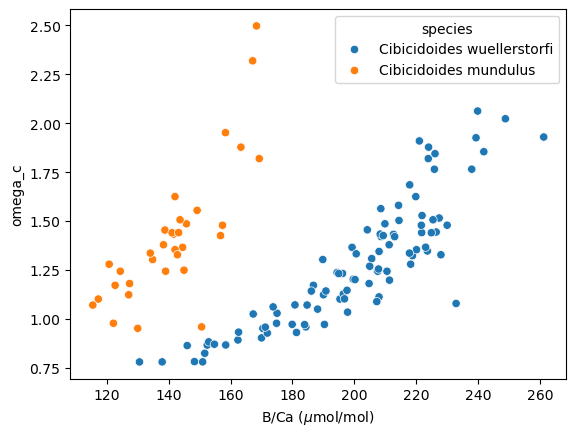

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.scatterplot(data=Yu_Elder_df, x='B_Ca_umolmol', y='omega_c', hue='species')
ax.set_xlabel(r'B/Ca ($\mu$mol/mol)')
plt.show()



With a little data transformation we can get a more linear correlation

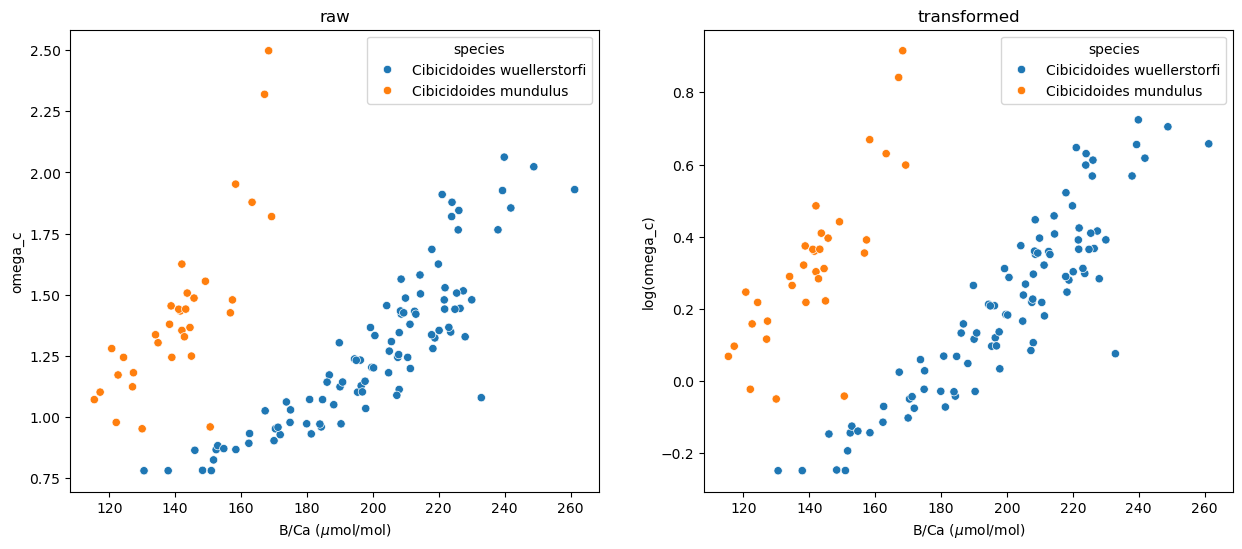

In [6]:
import numpy as np
Yu_Elder_df['log(omega_c)']=np.log(Yu_Elder_df['omega_c'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.scatterplot(ax=ax[0], data=Yu_Elder_df, x='B_Ca_umolmol', y='omega_c', hue='species')
ax[0].set_title('raw')
ax[0].set_xlabel(r'B/Ca ($\mu$mol/mol)')


sns.scatterplot(ax=ax[1], data=Yu_Elder_df, x='B_Ca_umolmol', y='log(omega_c)', hue='species')
ax[1].set_title('transformed')
ax[1].set_xlabel(r'B/Ca ($\mu$mol/mol)')

plt.show()



Create functions for the fit and prediction

In [7]:
import statsmodels.api as sm

def linregress(df, x_transform=None , y_transform=None, features='B_Ca_umolmol', target='omega_c'):
    
    X=df[features].values
    y=df[target].values
    if x_transform != None:
        X=x_transform(X)
    if y_transform != None:
        y=y_transform(y)
    
    #Reshape and add intercept to bracketed values
    Xwint=np.empty(shape=(len(X), 2), dtype=np.float64)
    Xwint[:,0]=1
    Xwint[:, 1]=X
    #reshape true values
    Y=y.reshape(-1, 1)

    mdl = sm.OLS(Y, Xwint)
    res_ols = mdl.fit()

    return res_ols


def linpred(xpredict, mdl, x_transform=None, y_transform=None):
    
    
    if x_transform != None:
        xpredict=x_transform(xpredict)
    
    if type(xpredict)==float:
        xpredwint=np.array([1, xpredict])
    else:
        xpredwint=np.empty(shape=(len(xpredict), 2), dtype=np.float64)
        xpredwint[:,0]=1
        xpredwint[:, 1]=xpredict
    ypred=mdl.predict(xpredwint)
    
    if y_transform != None:
        ypred=y_transform(ypred)
    
    return ypred


Text(0, 0.5, '$\\Omega_c$')

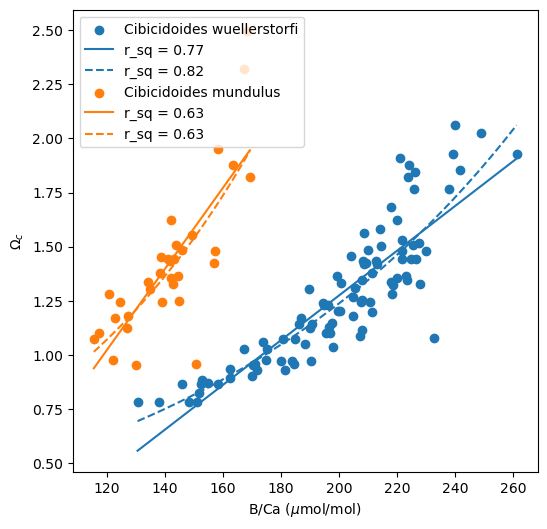

In [8]:

species_names=pd.unique(Yu_Elder_df['species'])
species_linear_dict={}
species_log_dict={}
colors=plt.rcParams['axes.prop_cycle'].by_key()['color'][0:len(species_names)]
species_col=dict(zip(species_names, colors))

fig, ax =plt.subplots(figsize=(6, 6))
for species in species_names:
    df=Yu_Elder_df.loc[Yu_Elder_df['species']==species]
    
    X=df['B_Ca_umolmol']
    Y=df['omega_c']
    
    xpredict=np.linspace(min(X), max(X), 30)
    
    linmdl= linregress(df)
    logmdl = linregress(df, y_transform=np.log)
    
    species_linear_dict[species]=linmdl
    species_log_dict[species]=logmdl
    
    species_short=species.split(' ')[1]
    
    ax.scatter(X, Y,color=species_col[species], label=species)
    ax.plot(xpredict, linpred(xpredict, linmdl), color=species_col[species], 
               label=f'r_sq = {linmdl.rsquared:.2f}')
    ax.plot(xpredict, linpred(xpredict, logmdl, y_transform=np.exp), color=species_col[species], 
               label=f'r_sq = {logmdl.rsquared:.2f}', ls='dashed')
    
ax.legend()
ax.set_xlabel(r'B/Ca ($\mu$mol/mol)')
ax.set_ylabel(r'$\Omega_c$')


    
    

## Import foram database

Import the data and do some cleaning to add paleodepths, remove 690B (due to it having no absolute ages), and converting any sample_id that is an integer to something more unique.

In [14]:
cwd=Path(os.getcwd())
data_path=cwd.parent.absolute()/"data"


excel_file_path = data_path/"foram_dataset.xlsx"

# Read all sheets from the Excel file into a dictionary of DataFrames
excel_data = pd.read_excel(excel_file_path, sheet_name=None)

foram_df=pd.DataFrame()
# Iterate through the sheets and store each DataFrame in the dictionary
for sheet_name, core_df in excel_data.items():
    core_df.insert(0, 'core', sheet_name)
    foram_df=pd.concat([foram_df, core_df])

foram_df.reset_index(drop=True, inplace=True)


#1262 paleodepth
foram_df.loc[foram_df['core']=='1262', 'palaeo_depth_m']=np.interp(foram_df.loc[foram_df['core']=='1262', 'age_Ma'], [56, 66], [3000, 3500])

#drop 690B
foram_df.drop(index=foram_df.index[foram_df['core']=='690B'], inplace=True)

#convert sample names that are single digits to core_digit.
foram_df['sample_id']=np.where(foram_df['sample_id'].str.isdigit(), 
                               foram_df['core'].astype(str)+'_'+foram_df['sample_id'].astype(str), 
                               foram_df['sample_id'])

foram_df['sample_mix_id']=np.where(foram_df['sample_id'].str.isdigit(), 
                               foram_df['core'].astype(str)+'_'+foram_df['sample_mix_id'].astype(str), 
                               foram_df['sample_mix_id'])


### Find $\Omega$ values using B/Ca data and previous fits

Fit data and plot Cibs

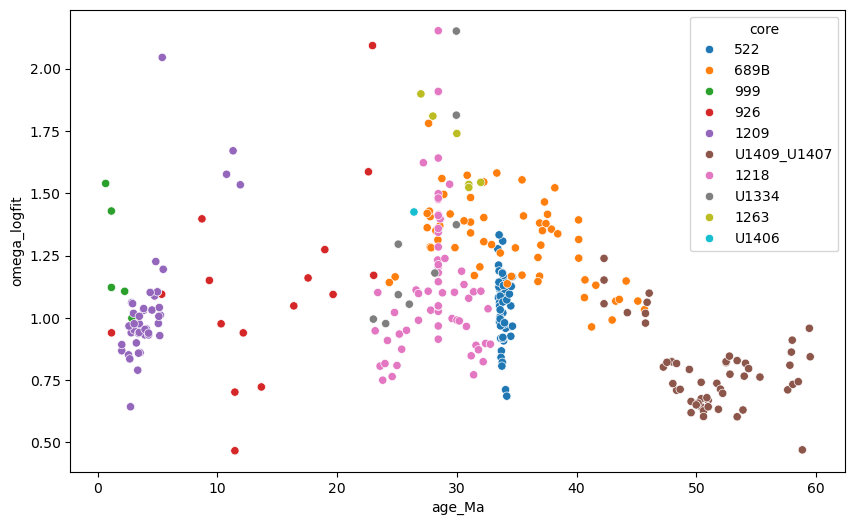

In [26]:

#Use B11 corrected to C. mundulus if available
foram_df['B11_species_corrected']=np.where(pd.isnull(foram_df['B11 corrected to C. mundulus']), 
                                           foram_df['B11'], 
                                           foram_df['B11 corrected to C. mundulus'])



#Perform linear and log fits
foram_df['omega_linfit']=linpred(foram_df['B11_species_corrected'].values, linmdl)
foram_df['omega_logfit']=linpred(foram_df['B11_species_corrected'].values, logmdl, y_transform=np.exp)

#isolate Cibicidoides for plotting
cibs_df=foram_df.dropna(subset='species', axis=0)
cibs_df=cibs_df.loc[cibs_df['species'].str.contains('Cibicidoides')]

#plot
fig, ax =plt.subplots(figsize=(10, 6))
sns.scatterplot(data=cibs_df, x='age_Ma', y='omega_logfit', hue='core')
plt.show()

Create depth correction for $\Omega$ based on the following relationship:

$$
\frac{K^*_{deep}}{K^*_{surface}} = e^{-\frac{\Delta V}{R(T-273.15)}P+0.5\frac{\Delta k}{R(T-273.15)}P^2} = \frac{\Omega _{surface}}{\Omega _{deep}}
$$

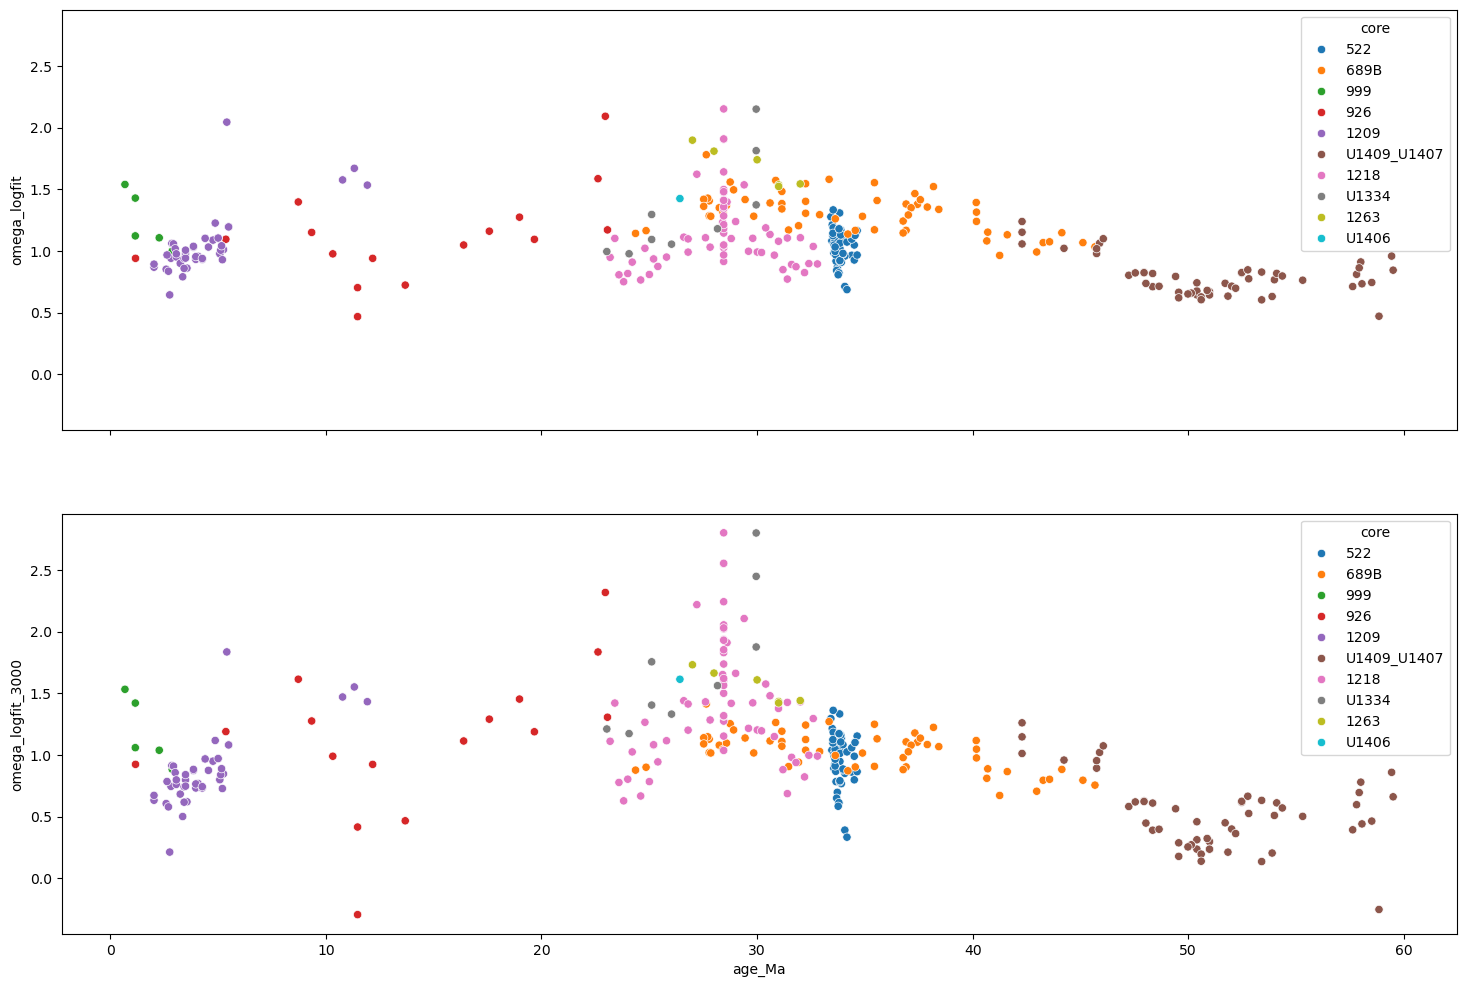

In [28]:
def omega_depth_correction(omega, depth, temp=2, newdepth=0):
    pressure_coefficients = kgen.coefs.K_presscorr_coefs
    pressure_correction = kgen.K_functions.calc_pressure_correction(coefficients=pressure_coefficients['KspC'], p_bar=depth_m_to_pressure_bar(depth), temp_c=temp)
    omega0=omega*pressure_correction
    pressure_correction = kgen.K_functions.calc_pressure_correction(coefficients=pressure_coefficients['KspC'], p_bar=depth_m_to_pressure_bar(newdepth), temp_c=temp)
    return omega0/pressure_correction


foram_df['omega_linfit_0']=omega_depth_correction(foram_df['omega_linfit'], foram_df['palaeo_depth_m'])
foram_df['omega_logfit_0']=omega_depth_correction(foram_df['omega_logfit'], foram_df['palaeo_depth_m'])
foram_df['omega_linfit_3000']=omega_depth_correction(foram_df['omega_linfit'], foram_df['palaeo_depth_m'], newdepth=3000)
foram_df['omega_logfit_3000']=omega_depth_correction(foram_df['omega_linfit'], foram_df['palaeo_depth_m'], newdepth=3000)

#save to disk
foram_df.to_csv(data_path/"foram_dataframe.csv")

cibs_df=foram_df.dropna(subset='species', axis=0)
cibs_df=cibs_df.loc[cibs_df['species'].str.contains('Cibicidoides')]

#plot
fig, ax =plt.subplots(nrows=2, ncols=1,  figsize=(18, 12), sharex=True, sharey=True)
sns.scatterplot(ax=ax[0], data=cibs_df, x='age_Ma', y='omega_logfit', hue='core')
sns.scatterplot(ax=ax[1], data=cibs_df, x='age_Ma', y='omega_logfit_3000', hue='core')
plt.show()

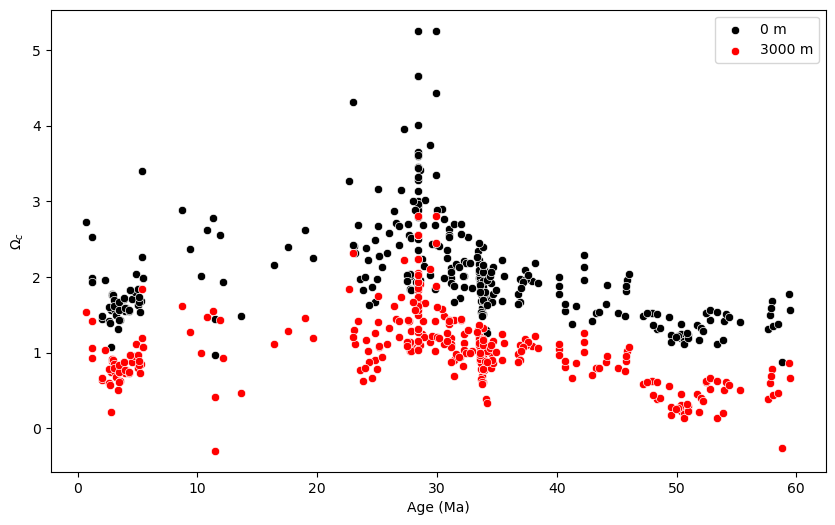

In [31]:
#plot
fig, ax =plt.subplots(figsize=(10, 6))
sns.scatterplot(data=cibs_df, x='age_Ma', y='omega_logfit_0', color='black')
sns.scatterplot(data=cibs_df, x='age_Ma', y='omega_logfit_3000', color='red')
ax.set_ylabel(r'$\Omega_c$')
ax.set_xlabel('Age (Ma)')
plt.legend(['0 m', '3000 m'])
plt.show()

## Calculate \[$CO_3^{2-}$ ] by using \[Ca] and \[Mg] reconstructions

### Import \[Ca] and \[Mg] data

Also need paleo temp?? Mg/Ca??

In [35]:
Ca_df=pd.read_excel(data_path/"calcium_magnesium.xlsx", sheet_name='calcium')
Mg_df=pd.read_excel(data_path/"calcium_magnesium.xlsx", sheet_name='magnesium')

### Interpolate \[Ca] and \[Mg] for each sample

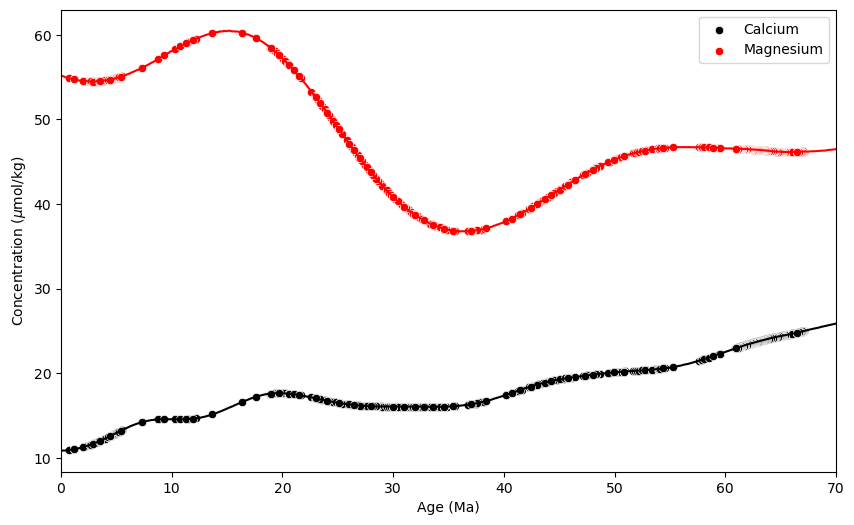

In [39]:

#perform linear interpolation on age_Ma in foram_df to get calcium and magnesium values
foram_df['Ca_sw']=np.interp(foram_df['age_Ma'], Ca_df['age'], Ca_df['median'])
foram_df['Mg_sw']=np.interp(foram_df['age_Ma'], Mg_df['age'], Mg_df['median'])

#plot
fig, ax =plt.subplots(figsize=(10, 6))
sns.scatterplot(data=foram_df, x='age_Ma', y='Ca_sw', color='black')
sns.scatterplot(data=foram_df, x='age_Ma', y='Mg_sw', color='red')
sns.lineplot(data=Ca_df, x='age', y='median', color='black')
sns.lineplot(data=Mg_df, x='age', y='median', color='red')
ax.set_ylabel(r'Concentration ($\mu$mol/kg)')
ax.set_xlabel('Age (Ma)')
ax.set_xlim(0, 70)
plt.legend(['Calcium', 'Magnesium'])